In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions


In [2]:
@tf.function
def create_adversarial_pattern(model, input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad


In [3]:
def get_gradcam_heatmap_conv(model, image, class_idx, last_conv_layer_name="Conv_1", use_softmax=True):
    """
    Grad-CAM heatmap for pre-softmax (logits) or post-softmax.
    """
    # Get last convolutional layer output
    last_conv_layer = model.get_layer(last_conv_layer_name).output
    if use_softmax:
        output_tensor = model.output  # post-softmax
    else:
        output_tensor = model.layers[-2].output  # pre-softmax logits

    grad_model = tf.keras.models.Model(model.input, [last_conv_layer, output_tensor])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        score = predictions[:, class_idx]

    grads = tape.gradient(score, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap)
    return heatmap

In [4]:
def overlay_heatmap(heatmap, image, alpha=0.4, colormap='jet'):
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], [224, 224], method='bilinear').numpy()[..., 0]
    heatmap = np.uint8(255 * heatmap)
    cmap = plt.get_cmap(colormap)
    heatmap_colored = cmap(heatmap)[:, :, :3]
    image = (image[0] + 1) / 2
    overlaid_image = heatmap_colored * alpha + image * (1 - alpha)
    return overlaid_image


232528/232528 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


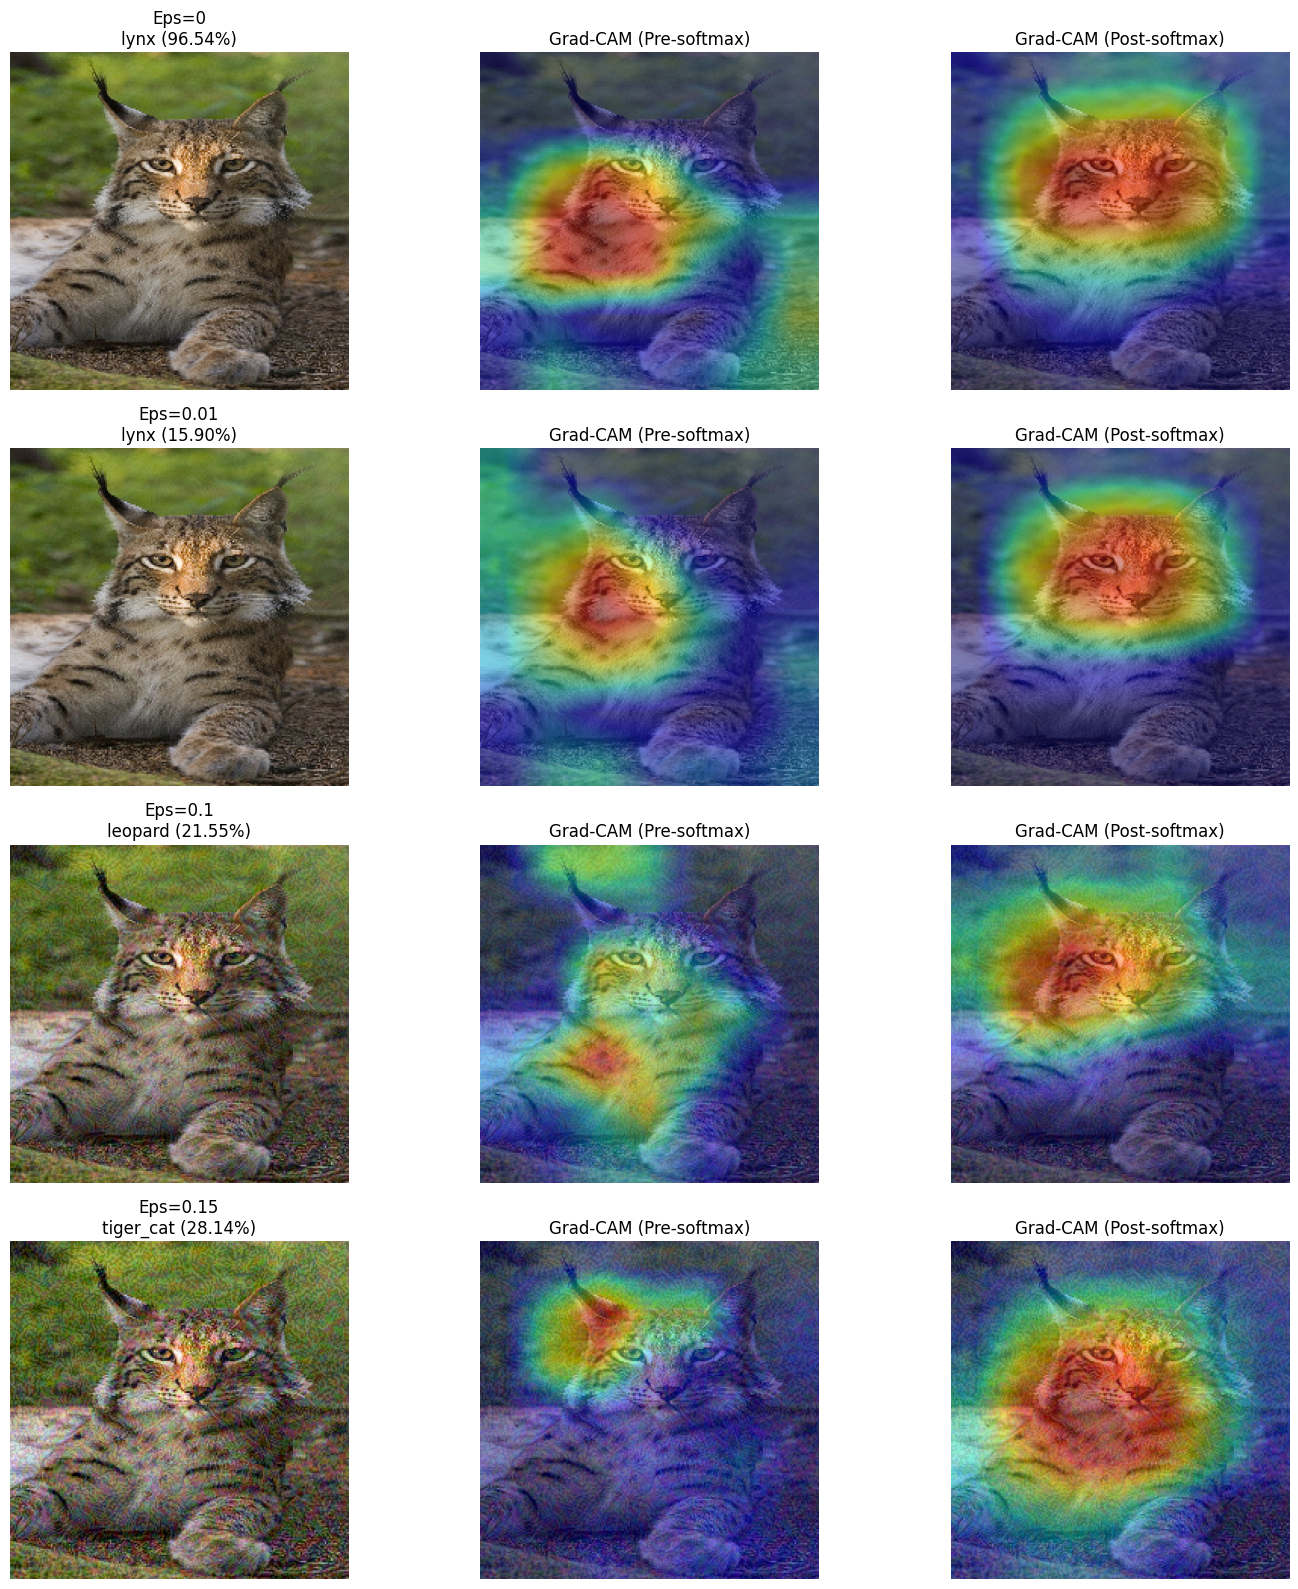

In [9]:
model = mobilenet_v2.MobileNetV2(weights="imagenet")
model.trainable = False
img_path = tf.keras.utils.get_file(
'Lynx_ImageNet.jpg',
'https://upload.wikimedia.org/wikipedia/commons/6/68/Lynx_lynx_poing.jpg'
)

img_raw = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img_raw)
img_batch = np.expand_dims(img, axis=0)
img_batch = preprocess_input(img_batch)
img_batch = tf.convert_to_tensor(img_batch, dtype=tf.float32)
loss_object = tf.keras.losses.CategoricalCrossentropy()

epsilons = [0, 0.01, 0.1, 0.15]
pred = model.predict(img_batch)
label_idx = np.argmax(pred[0])
label_onehot = tf.one_hot(label_idx, pred.shape[-1])

plt.figure(figsize=(15, len(epsilons)*4))

for i, eps in enumerate(epsilons):
    # Apply FGSM
    adv_x = img_batch + eps * create_adversarial_pattern(model, img_batch, tf.expand_dims(label_onehot, axis=0))
    adv_x = tf.clip_by_value(adv_x, -1, 1)

    # Get predictions for adversarial image
    adv_pred = model.predict(adv_x)
    decoded = decode_predictions(adv_pred, top=1)[0][0]
    class_idx = np.argmax(adv_pred[0])
    confidence = decoded[2]*100

    # Compute Grad-CAM heatmaps
    heatmap_logits = get_gradcam_heatmap_conv(model, adv_x, class_idx, use_softmax=False)  # Pre-softmax
    heatmap_probs  = get_gradcam_heatmap_conv(model, adv_x, class_idx, use_softmax=True)   # Post-softmax

    # Overlay heatmaps
    overlay_logits = overlay_heatmap(heatmap_logits, adv_x)
    overlay_probs  = overlay_heatmap(heatmap_probs, adv_x)

    heatmap_logits = heatmap_logits / (tf.reduce_max(heatmap_logits) + 1e-8)

    # -------------------------
    # Plot: Image + Grad-CAM pre + Grad-CAM post
    # -------------------------
    plt.subplot(len(epsilons), 3, 3*i+1)
    plt.imshow((adv_x[0]+1)/2)
    plt.title(f"Eps={eps}\n{decoded[1]} ({confidence:.2f}%)")
    plt.axis("off")

    plt.subplot(len(epsilons), 3, 3*i+2)
    plt.imshow(overlay_logits)
    plt.title("Grad-CAM (Pre-softmax)")
    plt.axis("off")

    plt.subplot(len(epsilons), 3, 3*i+3)
    plt.imshow(overlay_probs)
    plt.title("Grad-CAM (Post-softmax)")
    plt.axis("off")

plt.tight_layout()
plt.show()
